# Will McFarland

## Research question/interests
I would like to analyze the librosa data to learn more about how a genre might be able to be identified by the auditory features of a song.

## Exploratory Data Analysis

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

Lets look at tracks first.
Loading the data

In [2]:
tracks = pd.read_csv("../data/raw/tracks.csv", low_memory=False)

What does the data look like at a glance?

In [3]:
tracks.head()

,Unnamed: 0,album,album.1,album.2,album.3,album.4,album.5,album.6,album.7,album.8,...,track.10,track.11,track.12,track.13,track.14,track.15,track.16,track.17,track.18,track.19
0,NaN,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
1,track_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
4,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World


This doesn't show us all the columns, so lets view a list of them all. Unfortunetly the column names are kind of spread between the first 2 rows (i.e. the row pandas assigned to the header and row 0), so lets print those 2 values together for each column.

In [4]:
tracks.iloc[0] # This will print the row header and the vale at row 0 for each column

Unnamed: 0                  NaN
album                  comments
album.1            date_created
album.2           date_released
album.3                engineer
album.4               favorites
album.5                      id
album.6             information
album.7                 listens
album.8                producer
album.9                    tags
album.10                  title
album.11                 tracks
album.12                   type
artist        active_year_begin
artist.1        active_year_end
artist.2      associated_labels
artist.3                    bio
artist.4               comments
artist.5           date_created
artist.6              favorites
artist.7                     id
artist.8               latitude
artist.9               location
artist.10             longitude
artist.11               members
artist.12                  name
artist.13      related_projects
artist.14                  tags
artist.15               website
artist.16        wikipedia_page
set     

We will properly rename all of the columns in the analysis pipeline, but for the purposes of this EDA, lets just look at a few columns and rename them manually.

We have to remember here to use the header names.

In [5]:
track_subset = tracks[['Unnamed: 0', 'track.7', 'artist.12', 'album.2']].rename(columns={'Unnamed: 0': 'track id', 'track.7': 'genre', 'artist.12': 'artist name', 'album.2': 'release date'}).dropna(axis=0, how='any')
track_subset

,track id,genre,artist name,release date
2,2,Hip-Hop,AWOL,2009-01-05 00:00:00
3,3,Hip-Hop,AWOL,2009-01-05 00:00:00
4,5,Hip-Hop,AWOL,2009-01-05 00:00:00
5,10,Pop,Kurt Vile,2008-02-06 00:00:00
11,134,Hip-Hop,AWOL,2009-01-05 00:00:00
...,...,...,...,...
106570,155315,Rock,Spowder,2017-02-17 00:00:00
106571,155316,Rock,Spowder,2017-02-17 00:00:00
106572,155317,Rock,Spowder,2017-02-17 00:00:00
106573,155318,Rock,Spowder,2017-02-17 00:00:00


So we have genre, artist name, and release date. Lets graph it!

Starting with just genre...

<AxesSubplot:>

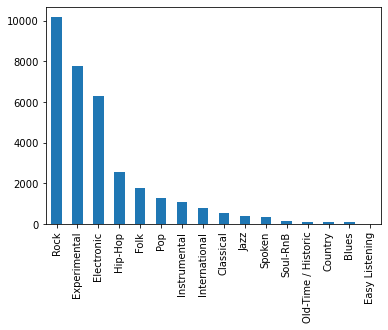

In [6]:
plt.figure()
genre_sizes = track_subset.iloc[:, 1].value_counts()
genre_sizes.plot(kind='bar')

Now let's see genres over time...

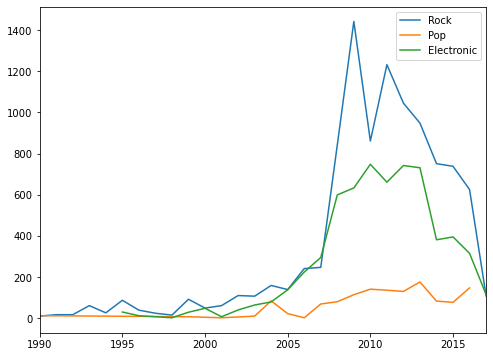

In [7]:
plt.figure(figsize=(8,6))

# Add column that is just year
track_subset['year'] = pd.DatetimeIndex(track_subset['release date']).year

# Get value counts of year and genre together
genres_years = track_subset[['year', 'genre']]
genres_years  = pd.DataFrame(track_subset[['year', 'genre']].value_counts()).reset_index().rename(columns={0: 'count'}).sort_values(['year', 'genre'])

#plt.plot(genres_years.loc[genres_years['genre'] == 'Rock', 'year'], genres_years.loc[genres_years['genre'] == 'Rock', 'count'])
# Plot number of tracks per year by genre
# for g in genres_years['genre'].unique():
for g in ['Rock', 'Pop', 'Electronic']:
    plt.plot(genres_years.loc[genres_years['genre'] == g, 'year'], genres_years.loc[genres_years['genre'] == g, 'count'], label=g)

# Most of our data is between 1990 and 2017
plt.xlim([1990, 2017])

# Show legend
plt.legend()

The librosa data is much more abstract. We will dive into this more in the future, but for now lets look at one column that is easy to understand.
Root Mean Square Energy (RMSE) represents the energy of a given cell of autio.

In [64]:
rmse = pd.read_csv("../data/raw/features.csv", nrows=6000, skiprows=[0,1,2], usecols=[0, 395])
rmse = rmse.rename(columns={"track_id":"track id", "Unnamed: 395":"rmse_mean"})
track_subset['track id'] = track_subset['track id'].astype(int) # Track ID needs to be int type (it starts as string for some reason)
rmse_meta = pd.merge(track_subset, rmse, on="track id", how="inner") # Combine metadata with RMSE

Text(0, 0.5, 'Mean RMSE')

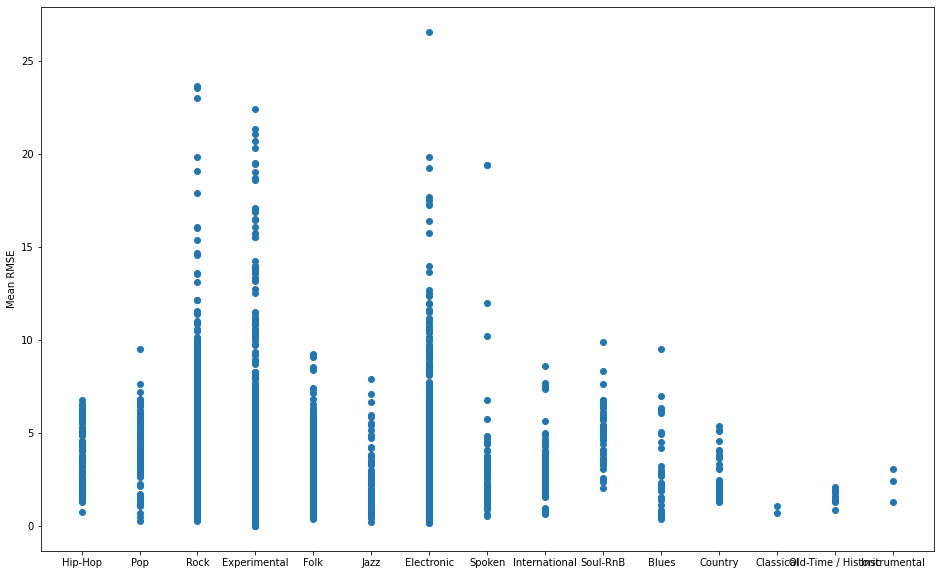

In [65]:
plt.figure(figsize=(16,10))

plt.scatter(rmse_meta['genre'], rmse_meta['rmse_mean'])

plt.ylabel("Mean RMSE")

Another (perhaps more clear) way of visualizing this data is through individual histograms for each genre.

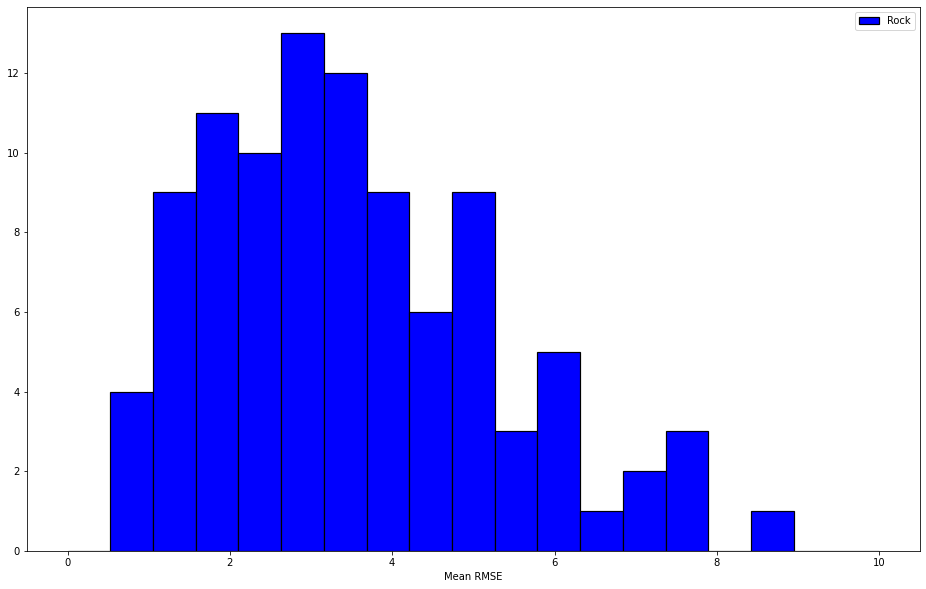

In [105]:
plt.figure(figsize=(16,10))

# Take equally sized samples for 3 genres that exemplify different energies: Rock, Jazz, Electronic
rock = rmse_meta.loc[rmse_meta['genre'] == 'Rock', 'rmse_mean'].head(100)
hiphop = rmse_meta.loc[rmse_meta['genre'] == 'Hip-Hop', 'rmse_mean'].head(100)
spoken = rmse_meta.loc[rmse_meta['genre'] == 'Spoken', 'rmse_mean'].head(100)

bins = np.linspace(0, 10, 20)

plt.hist(rock, bins, label='Rock', color='blue', edgecolor='black', linewidth=1.2)
plt.xlabel('Mean RMSE')
plt.legend()

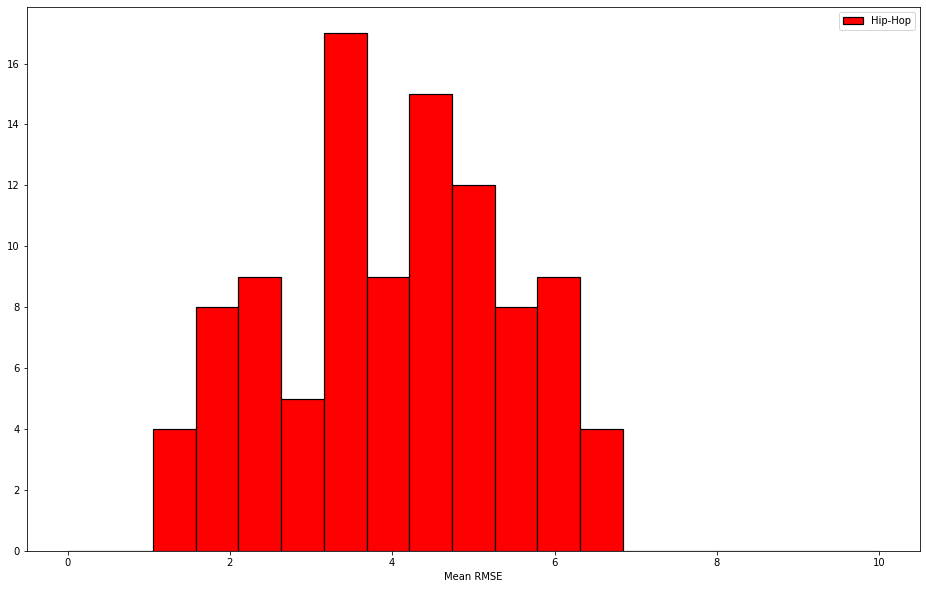

In [104]:
plt.figure(figsize=(16,10))
plt.hist(hiphop, bins, label='Hip-Hop', color='red', edgecolor='black', linewidth=1.2)
plt.xlabel('Mean RMSE')
plt.legend()

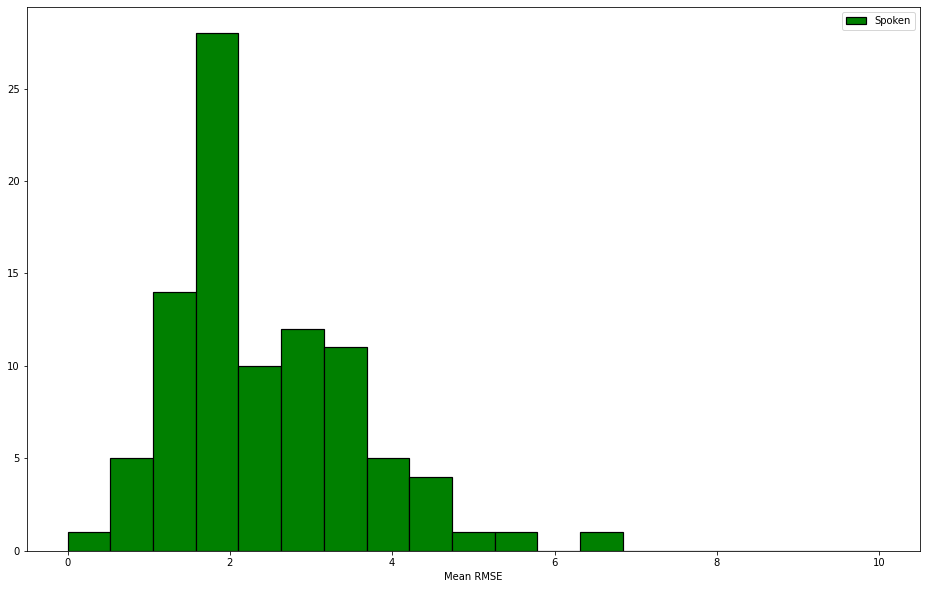

In [106]:
plt.figure(figsize=(16,10))
plt.hist(spoken, bins, label='Spoken', color='green', edgecolor='black', linewidth=1.2)
plt.xlabel('Mean RMSE')
plt.legend()

These histograms do a good job showing how energy changes with different genres. Unfortunetely we don't have any genres that have consistently high energies such as metal, but we do have enough variety to see some trends. For example, rock encompasses a very wide amount of energies (rock ballads vs hard rock for ex.). Comparing this to hip-hop, we see a much more consistent level of energy due to the more narrow variety of energies encompassed in that genre (at least in the sample tracks in this dataset). Spoken-word audio makes a good benchmark as it we expect that to be consistently low-energy, which we see in the final histogram.

## Analysis Pipeline - Tracks

### Cleaning the tracks data

Tracks data starts on row 4, and the first 2 rows should be combined to form the column names.

In [ ]:
for i in range(0, len(tracks.columns)):
    # Remove dot and number at end of original name
    orig = re.sub('[\\.][0-9]*', '', tracks.columns[i]) # Use a regex to remove dot followed by any number of numeric digits
    tracks.columns.values[i] = orig + ' ' + str(tracks.iloc[0,i]) # Append specific name (first column after names) to orig 

# Now remove first 2 columns after column titles
tracks = tracks.drop([0, 1])

# Rename first unnamed column to id
tracks.columns.values[0] = 'id'

tracks.head()

List all of the row names after cleaning

Remove columns that we're not likely to use

In [ ]:
tracks = tracks[['id', 'track title', 'artist name', 'album title', 'track genre_top']]

In [ ]:
tracks

### Librosa Data
Understanding what the columns mean

In [ ]:
features